<a href="https://colab.research.google.com/github/Amrutha369/voice-spoofing-detection/blob/main/voice_spoofing_detection_using_cnn_lstm_gru_Multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikeras

In [2]:

!pip install tensorflow-io
import os
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt #plotting library
import numpy as np #numerical computing
import tensorflow as tf
import tensorflow_io as tfio
import seaborn as sns # statistical data visualization
from IPython.display import Audio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 16.1 MB/s eta 0:00:00


In [3]:
# Audio params
SAMPLE_RATE = 16000
DURATION = 20.0 # duration in second
AUDIO_LEN = int(SAMPLE_RATE * DURATION)

# Spectrogram params
N_MELS = 128 # freq axis
N_FFT = 2048
SPEC_WIDTH = 256 #
HOP_LEN = 512 # non-overlap region
FMAX = SAMPLE_RATE//2 # max frequency

# CNN params
NUM_CLASSES = 4 # bonafide or spoof



In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# Directory and protocol definitions
base_path = '/content/drive/MyDrive/dataset/LA'
protocol_dir = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols')
train_dir = os.path.join(base_path, 'ASVspoof2019_LA_train', 'flac')
dev_dir = os.path.join(base_path, 'ASVspoof2019_LA_dev', 'flac')
eval_dir = os.path.join(base_path, 'ASVspoof2019_LA_eval', 'flac')

In [6]:
# Function to form the full path of a file
def get_file_path(directory, filename):
    return os.path.join(directory, f'{filename}.flac')

In [7]:
# Function to read the dataset
def read_dataset(protocol_path, directory):
    """Reads the dataset from a protocol file and returns a DataFrame."""
    df = pd.read_csv(protocol_path, sep=' ', header=None, names=['speaker_id', 'filename', 'system_id', 'null', 'class_name'])
    df['filepath'] = df['filename'].apply(lambda x: get_file_path(directory, x))
    df.drop('null', axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

# Function to convert class_name to integer
def label_to_int(class_name):
    if class_name == 'real':
        return 0
    elif class_name == 'synthesised':
        return 1
    elif class_name == 'converted':
        return 2
    elif class_name == 'replay':
        return 3
    else:
        return -1  # Handle unknown classes

# Add target column and subset to DataFrame
def add_columns(df, subset):
    df['target'] = df['class_name'].apply(label_to_int)
    df['subset'] = subset
    return df

# Take samples from each DataFrame
def sample_data_multiclass(df, n_synthesised, n_real, n_converted, n_replay):
    synthesised = df[df['class_name'] == 'synthesised'].head(n_synthesised)
    real = df[df['class_name'] == 'real'].head(n_real)
    converted = df[df['class_name'] == 'converted'].head(n_converted)
    replay = df[df['class_name'] == 'replay'].head(n_replay)
    return pd.concat([synthesised, real, converted, replay])

# Directory and protocol definitions
base_path = '/content/drive/MyDrive/dataset/LA'
protocol_dir = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols')
train_dir = os.path.join(base_path, 'ASVspoof2019_LA_train', 'flac')
dev_dir = os.path.join(base_path, 'ASVspoof2019_LA_dev', 'flac')
eval_dir = os.path.join(base_path, 'ASVspoof2019_LA_eval', 'flac')

# Create DataFrames for each dataset
train_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.train.trn.txt'), train_dir)
dev_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.dev.trl.txt'), dev_dir)
eval_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.eval.trl.txt'), eval_dir)

# Add columns to each DataFrame
train_df = add_columns(train_df, 'train')
dev_df = add_columns(dev_df, 'dev')
eval_df = add_columns(eval_df, 'eval')

# Take samples from each DataFrame by a different number
train_df = sample_data_multiclass(train_df, 175, 175, 175,175)
dev_df = sample_data_multiclass(dev_df, 37, 37, 37,37)
eval_df = sample_data_multiclass(eval_df, 37, 37, 37,37)

In [8]:
#Combine three dataframes into one dataframe
data_df = pd.concat([train_df, dev_df, eval_df], ignore_index=True)

In [9]:
data_df.head(len(data_df))

,speaker_id,filename,system_id,class_name,filepath,target,subset
0,LA_0098,LA_T_1000648,-,synthesised,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train
1,LA_0090,LA_T_1001169,-,synthesised,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train
2,LA_0098,LA_T_1001718,-,synthesised,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train
3,LA_0085,LA_T_1002656,-,synthesised,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train
4,LA_0085,LA_T_1004407,-,synthesised,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,1,train
...,...,...,...,...,...,...,...
991,PA_0084,PA_T_0005512,aaa,replay,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,3,eval
992,PA_0084,PA_T_0005513,aaa,replay,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,3,eval
993,PA_0084,PA_T_0005514,aaa,replay,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,3,eval
994,PA_0084,PA_T_0005515,aaa,replay,/content/drive/MyDrive/dataset/LA/ASVspoof2019...,3,eval


# Feature extraction

In [10]:
import librosa

def audio_to_spectrogram(filepath):
    # Load audio file using librosa
    audio, sample_rate = librosa.load(filepath)

    # Normalize the audio
    audio_norm = (audio - np.min(audio)) / (np.max(audio) - np.min(audio))
    # A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.
    # Compute the spectrogram using librosa
    spectrogram = librosa.feature.melspectrogram(y=audio_norm, sr=sample_rate)

    # Convert the spectrogram to decibels
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Add channel dimension
    spectrogram_db = np.expand_dims(spectrogram_db, axis=-1)

    # Resize spectrogram to the specified size
    image = tf.image.resize(spectrogram_db, [SPEC_WIDTH, N_MELS])

    return image

# Adding the spectrogram column to the DataFrame
data_df['spectrogram'] = data_df['filepath'].apply(audio_to_spectrogram)


In [11]:
# Splitting the data based on the 'subset' column
train_data = data_df[data_df['subset'] == 'train']
dev_data = data_df[data_df['subset'] == 'dev']
eval_data = data_df[data_df['subset'] == 'eval']

# Converting the list of spectrograms into NumPy arrays
X_train = np.stack(train_data['spectrogram'].to_list())
X_dev = np.stack(dev_data['spectrogram'].to_list())
X_eval = np.stack(eval_data['spectrogram'].to_list())

# Converting target into NumPy arrays
y_train = train_data['target'].to_numpy()
y_dev = dev_data['target'].to_numpy()
y_eval = eval_data['target'].to_numpy()

In [12]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")#Contains target labels
print(f"X_dev shape: {X_dev.shape}")
print(f"y_dev shape: {y_dev.shape}")
print(f"X_eval shape: {X_eval.shape}")
print(f"y_eval shape: {y_eval.shape}")

X_train shape: (700, 256, 128, 1)
y_train shape: (700,)
X_dev shape: (148, 256, 128, 1)
y_dev shape: (148,)
X_eval shape: (148, 256, 128, 1)
y_eval shape: (148,)


# CNN Model (Multiclass)

In [ ]:
from tensorflow.keras.optimizers import Adam

def cnn_model(input_shape, num_classes):
    model = Sequential()
    # 1st conv layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # 2nd conv layer
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # 3rd conv layer
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # 4th conv layer
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    # Additional dense layer
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    # Output layer for multiclass classification
    model.add(Dense(num_classes, activation='softmax'))
    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Convert target labels to one-hot encoding for multiclass classification
from tensorflow.keras.utils import to_categorical

# Convert target labels to one-hot encoding
y_train_categorical = to_categorical(y_train, num_classes=NUM_CLASSES)
y_dev_categorical = to_categorical(y_dev, num_classes=NUM_CLASSES)
y_eval_categorical = to_categorical(y_eval, num_classes=NUM_CLASSES)

# Create the multiclass CNN model with Adam optimizer
multiclass_cnn_model =cnn_model((X_train.shape[1], X_train.shape[2], 1), NUM_CLASSES)

# Train the multiclass CNN model
multiclass_cnn_model.fit(X_train, y_train_categorical, epochs=50, batch_size=16)

# Compute accuracy on training data
train_accuracy = multiclass_cnn_model.evaluate(X_train, y_train_categorical)[1]
print(f"Accuracy on training data: {train_accuracy * 100:.2f}%")

# Compute accuracy on validation data
val_accuracy = multiclass_cnn_model.evaluate(X_dev, y_dev_categorical)[1]
print(f'Accuracy on validation data: {val_accuracy * 100:.2f}%')

# Compute accuracy on test data
test_accuracy = multiclass_cnn_model.evaluate(X_eval, y_eval_categorical)[1]
print(f'Accuracy on test data: {test_accuracy * 100:.2f}%')


In [ ]:
# Save the model
multiclass_cnn_model.save('/content/drive/MyDrive/save/voice-spoofing-detection-using-cnn-Multiclass.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
from tensorflow.keras.models import load_model
sample_audio_file_path = "/content/drive/MyDrive/dataset/LA/ASVspoof2019_LA_eval/flac/LA_T_6904517.flac"

print("Sample audio file:", sample_audio_file_path)
model_path = "/content/drive/MyDrive/save/voice-spoofing-detection-using-cnn-Multiclass.h5"  # Replace with actual path
multiclass_cnn_model = load_model(model_path)
# Creating spectrogram for the sample audio file
sample_audio_spectrogram = audio_to_spectrogram(sample_audio_file_path)
X_new = np.expand_dims(sample_audio_spectrogram, axis=0)

# Performing prediction
y_pred = multiclass_cnn_model.predict(X_new)

# Convert probabilities to classes by selecting the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# Map predicted classes to labels
class_labels = ['real', 'synthesised', 'converted','replay']  # Update with your actual class labels
y_pred_labels = [class_labels[pred] for pred in y_pred_classes]
print("Predicted class:", y_pred_labels[0])

Sample audio file: /content/drive/MyDrive/dataset/LA/ASVspoof2019_LA_eval/flac/LA_T_6904517.flac
1/1 [==============================] - 0s 137ms/step
Predicted class: real


5/5 [==============================] - 0s 8ms/step


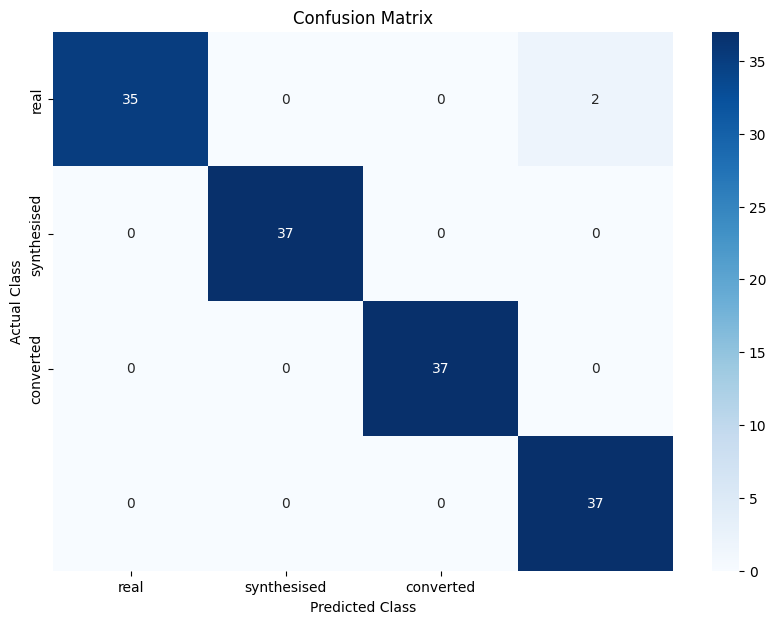

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have X_eval and y_eval datasets for testing

# Perform predictions on the evaluation set
y_eval_pred = multiclass_cnn_model.predict(X_eval)
y_eval_pred_classes = np.argmax(y_eval_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_eval, y_eval_pred_classes)

# Create a heatmap plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Show the plot
plt.show()


# LSTM Model

In [ ]:
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# architecture of the Sequential LSTM model
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(4, activation='softmax')  # Assuming 4 classes for multiclass classification
])

# Compile the model
learning_rate = 0.0001  # Adjust the learning rate as needed

# Compile the model with custom learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(X_train, y_train, epochs=80, batch_size=8, validation_data=(X_eval, y_eval))

# Evaluate the model
loss, accuracy = model.evaluate(X_eval, y_eval)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')




Epoch 1/80
88/88 [==============================] - 92s 954ms/step - loss: 1.2349 - accuracy: 0.4057 - val_loss: 1.0807 - val_accuracy: 0.5068
Epoch 2/80
88/88 [==============================] - 56s 633ms/step - loss: 1.0681 - accuracy: 0.4800 - val_loss: 0.9732 - val_accuracy: 0.4662
Epoch 3/80
88/88 [==============================] - 56s 642ms/step - loss: 1.0258 - accuracy: 0.5157 - val_loss: 0.9582 - val_accuracy: 0.5473
Epoch 4/80
88/88 [==============================] - 57s 652ms/step - loss: 0.9993 - accuracy: 0.5086 - val_loss: 0.9063 - val_accuracy: 0.5405
Epoch 5/80
88/88 [==============================] - 58s 658ms/step - loss: 0.9512 - accuracy: 0.5086 - val_loss: 0.9101 - val_accuracy: 0.5338
Epoch 6/80
88/88 [==============================] - 55s 631ms/step - loss: 0.9049 - accuracy: 0.5543 - val_loss: 0.8796 - val_accuracy: 0.5743
Epoch 7/80
88/88 [==============================] - 55s 626ms/step - loss: 0.9420 - accuracy: 0.5314 - val_loss: 1.0391 - val_accuracy: 0.5203

In [ ]:
model.save('/content/drive/MyDrive/save/voice-spoofing-detection-using-lstm-Multiclass.h5')

In [ ]:

import os
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/save/voice-spoofing-detection-using-lstm-Multiclass.h5"

model = load_model(model_path)

# add code to load model


sample_audio_file_path = "/content/drive/MyDrive/dataset/LA/ASVspoof2019_LA_eval/flac/LA_T_8487129.flac"

print("Sample audio file:", sample_audio_file_path)
# Make predictions
sample_audio_spectrogram = audio_to_spectrogram(sample_audio_file_path)

# Assuming the shape of the spectrogram is suitable for the model input
X_new = np.expand_dims(sample_audio_spectrogram, axis=0)

# Performing prediction
y_pred = model.predict(X_new)

# Convert probabilities to classes by selecting the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# Map predicted classes to labels
class_labels = ['real', 'synthesised', 'converted','replay']  # Update with your actual class labels
y_pred_labels = [class_labels[pred] for pred in y_pred_classes]

print("Predicted class:", y_pred_labels[0])



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Sample audio file: /content/drive/MyDrive/dataset/LA/ASVspoof2019_LA_eval/flac/LA_T_8487129.flac
1/1 [==============================] - 1s 954ms/step
Predicted class: synthesised


5/5 [==============================] - 0s 22ms/step


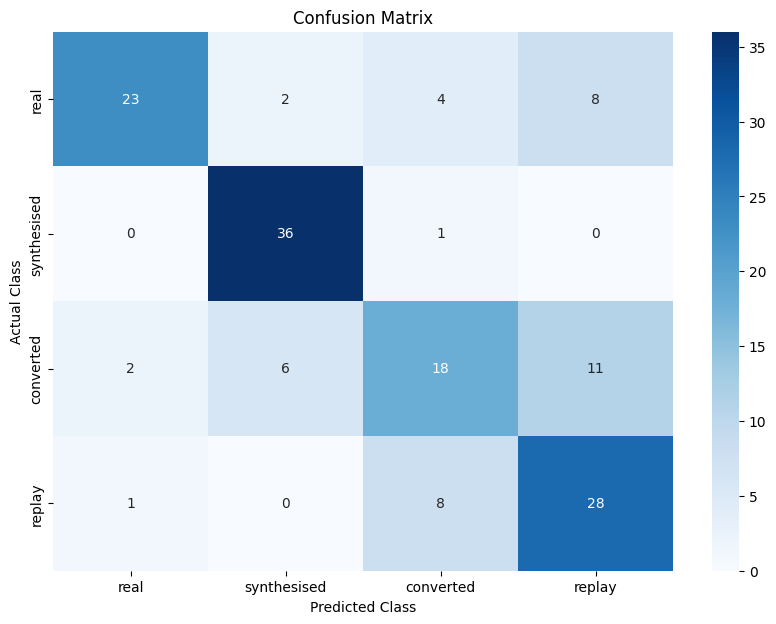

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Perform predictions on the evaluation set
y_eval_pred = model.predict(X_eval)
y_eval_pred_classes = np.argmax(y_eval_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_eval, y_eval_pred_classes)

# Create a heatmap plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Show the plot
plt.show()


# GRU Model

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Load and preprocess your dataset
# Assuming you have X_train, X_test, y_train, y_test after preprocessing

# Define the architecture of the Sequential GRU model
model = Sequential([
    GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(128),
    Dropout(0.2),
    Dense(4, activation='softmax')  # Assuming 4 classes for multiclass classification
])

# Compile the model
learning_rate = 0.00001  # Adjust the learning rate as needed

# Compile the model with custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=80, batch_size=8, validation_data=(X_eval, y_eval))

# Evaluate the model
loss, accuracy = model.evaluate(X_eval, y_eval)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/80
88/88 [==============================] - 60s 586ms/step - loss: 1.4528 - accuracy: 0.2386 - val_loss: 1.3824 - val_accuracy: 0.3446
Epoch 2/80
88/88 [==============================] - 50s 569ms/step - loss: 1.3796 - accuracy: 0.2829 - val_loss: 1.3541 - val_accuracy: 0.3446
Epoch 3/80
88/88 [==============================] - 49s 563ms/step - loss: 1.3786 - accuracy: 0.3043 - val_loss: 1.3335 - val_accuracy: 0.3919
Epoch 4/80
88/88 [==============================] - 51s 572ms/step - loss: 1.3529 - accuracy: 0.3029 - val_loss: 1.3163 - val_accuracy: 0.4054
Epoch 5/80
88/88 [==============================] - 51s 582ms/step - loss: 1.3370 - accuracy: 0.3443 - val_loss: 1.3009 - val_accuracy: 0.4459
Epoch 6/80
88/88 [==============================] - 49s 561ms/step - loss: 1.3177 - accuracy: 0.3843 - val_loss: 1.2853 - val_accuracy: 0.4595
Epoch 7/80
88/88 [==============================] - 50s 570ms/step - loss: 1.2940 - accuracy: 0.4071 - val_loss: 1.2703 - val_accuracy: 0.4527

In [ ]:
model.save('/content/drive/MyDrive/save/voice-spoofing-detection-using-gru-Multiclass.h5')

In [18]:

import os
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/save/voice-spoofing-detection-using-gru-Multiclass.h5"

model = load_model(model_path)

# add code to load model


sample_audio_file_path = "/content/drive/MyDrive/dataset/LA/ASVspoof2019_LA_eval/flac/test.flac"

print("Sample audio file:", sample_audio_file_path)
# Make predictions
sample_audio_spectrogram = audio_to_spectrogram(sample_audio_file_path)

# Assuming the shape of the spectrogram is suitable for the model input
X_new = np.expand_dims(sample_audio_spectrogram, axis=0)

# Performing prediction
y_pred = model.predict(X_new)

# Convert probabilities to classes by selecting the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# Map predicted classes to labels
class_labels = ['real', 'synthesised', 'converted','replay']  # Update with your actual class labels
y_pred_labels = [class_labels[pred] for pred in y_pred_classes]

print("Predicted class:", y_pred_labels[0])



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Sample audio file: /content/drive/MyDrive/dataset/LA/ASVspoof2019_LA_eval/flac/test.flac
1/1 [==============================] - 2s 2s/step
Predicted class: synthesised


5/5 [==============================] - 1s 287ms/step


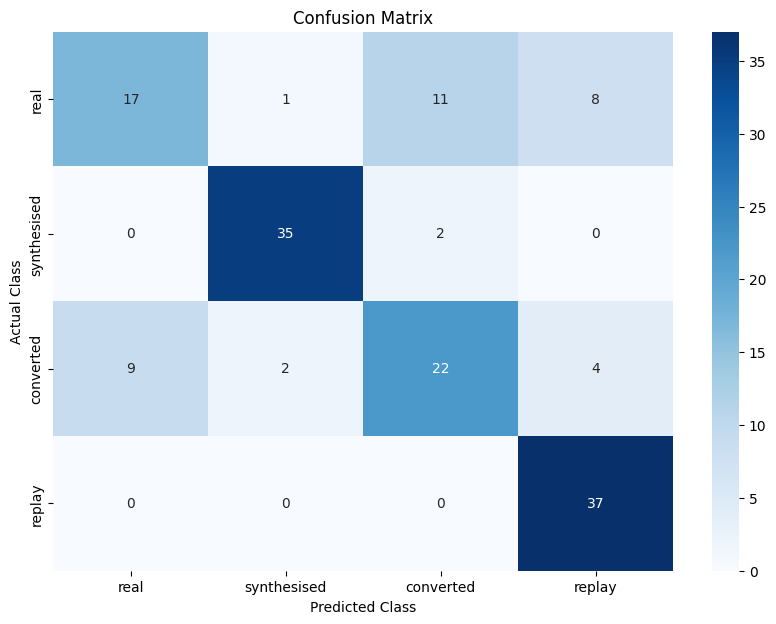

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have X_eval and y_eval datasets for testing

# Perform predictions on the evaluation set
y_eval_pred = model.predict(X_eval)
y_eval_pred_classes = np.argmax(y_eval_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_eval, y_eval_pred_classes)

# Create a heatmap plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Show the plot
plt.show()
